In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from modelnetvoxel_dataset import ModelNetDatasetVoxel
from cnn_model import *
from train_model import train_and_evaluate
from resnet_models import *
from torchinfo import summary

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

num_classes = 10

grid_size = 32
object_size = 28
pitch_rescale = 1
no_of_rotations = 4
DATA_DIR = f"ModelNet10Voxel_{grid_size}_{object_size}_{pitch_rescale}_{no_of_rotations}"

batch_size = 64
dataset = ModelNetDatasetVoxel(DATA_DIR, train=True)
train_datapoints = int(0.85 * len(dataset))
validation_datapoints = len(dataset) - train_datapoints
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_datapoints, validation_datapoints])
test_dataset = ModelNetDatasetVoxel(DATA_DIR, train=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training device: {device}")

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training device: cuda


In [2]:
train_class_distribution = np.zeros(num_classes)
validation_class_distribution = np.zeros(num_classes)

for index in train_dataset.indices:
    label = train_dataset.dataset[index][1]
    train_class_distribution[label] += 1

for index in validation_dataset.indices:
    label = validation_dataset.dataset[index][1]
    validation_class_distribution[label] += 1

print("Train class distribution (%): \t\t", np.round(train_class_distribution / train_class_distribution.sum() * 100,1))
print("Validation class distribution (%): \t", np.round(validation_class_distribution / validation_class_distribution.sum() * 100,1))

class_weights = torch.tensor(1 / (train_class_distribution / train_class_distribution.sum()), dtype=torch.float32).to(device)
print(class_weights)

# Use the sampler in DataLoader
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=int(os.cpu_count()))
validation_dataloader = DataLoader(validation_dataset, batch_size, shuffle=True, num_workers=int(os.cpu_count()))
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=int(os.cpu_count()))

model = Simple3DCNN(10).to(device)
print(summary(model, input_size=(batch_size, 1, grid_size, grid_size, grid_size)))

Train class distribution (%): 		 [22.2 17.   8.4  5.   2.7  5.  12.9  5.1 11.7  9.9]
Validation class distribution (%): 	 [22.5 17.   9.8  4.8  2.7  5.3 12.9  4.4 11.1  9.6]
tensor([ 4.4960,  5.8664, 11.8818, 19.8377, 37.6917, 20.1620,  7.7449, 19.5237,
         8.5179, 10.1337], device='cuda:0')
Layer (type:depth-idx)                   Output Shape              Param #
Simple3DCNN                              --                        --
├─Conv3d: 1-1                            [64, 16, 32, 32, 32]      448
├─MaxPool3d: 1-2                         [64, 16, 16, 16, 16]      --
├─Conv3d: 1-3                            [64, 32, 16, 16, 16]      13,856
├─MaxPool3d: 1-4                         [64, 32, 8, 8, 8]         --
├─Conv3d: 1-5                            [64, 64, 8, 8, 8]         55,360
├─MaxPool3d: 1-6                         [64, 64, 4, 4, 4]         --
├─Linear: 1-7                            [64, 64]                  262,208
├─Dropout: 1-8                           [64, 64]    

In [3]:
# Define your model, optimizer, and loss function
%load_ext autoreload
%autoreload 2
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_and_evaluate(
    model, 
    train_dataloader, 
    validation_dataloader,
    loss_fn, 
    opt,
    num_epochs=50,
    patience_epochs=5,
    checkpoint_path="checkpoint.pt",
    resume_training=False,
    device=device
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EPOCH 0: Train loss: 0.06 	: 100%|██████████| 213/213 [00:06<00:00, 32.84it/s]


Average training loss: 1.121	 Training accuracy: 0.625


100%|██████████| 38/38 [00:01<00:00, 23.96it/s]


Average validation loss: 0.541	Validation accuracy: 0.825
Update model!!!


# EPOCH 1: Train loss: 0.43 	: 100%|██████████| 213/213 [00:06<00:00, 33.08it/s]


Average training loss: 0.567	 Training accuracy: 0.811


100%|██████████| 38/38 [00:01<00:00, 23.81it/s]


Average validation loss: 0.451	Validation accuracy: 0.851
Update model!!!


# EPOCH 2: Train loss: 0.22 	: 100%|██████████| 213/213 [00:06<00:00, 33.04it/s]


Average training loss: 0.449	 Training accuracy: 0.850


100%|██████████| 38/38 [00:01<00:00, 23.85it/s]


Average validation loss: 0.354	Validation accuracy: 0.891
Update model!!!


# EPOCH 3: Train loss: 0.04 	: 100%|██████████| 213/213 [00:06<00:00, 33.05it/s]


Average training loss: 0.362	 Training accuracy: 0.880


100%|██████████| 38/38 [00:01<00:00, 24.32it/s]


Average validation loss: 0.289	Validation accuracy: 0.912
Update model!!!


# EPOCH 4: Train loss: 0.52 	: 100%|██████████| 213/213 [00:06<00:00, 33.07it/s]


Average training loss: 0.308	 Training accuracy: 0.896


100%|██████████| 38/38 [00:01<00:00, 24.21it/s]


Average validation loss: 0.322	Validation accuracy: 0.896
Incrementing patience epoch count:  1


# EPOCH 5: Train loss: 0.29 	: 100%|██████████| 213/213 [00:06<00:00, 32.88it/s]


Average training loss: 0.285	 Training accuracy: 0.903


100%|██████████| 38/38 [00:01<00:00, 24.01it/s]


Average validation loss: 0.215	Validation accuracy: 0.929
Update model!!!


# EPOCH 6: Train loss: 0.01 	: 100%|██████████| 213/213 [00:06<00:00, 33.02it/s]


Average training loss: 0.244	 Training accuracy: 0.914


100%|██████████| 38/38 [00:01<00:00, 23.90it/s]


Average validation loss: 0.202	Validation accuracy: 0.934
Update model!!!


# EPOCH 7: Train loss: 0.72 	: 100%|██████████| 213/213 [00:06<00:00, 32.88it/s]


Average training loss: 0.217	 Training accuracy: 0.926


100%|██████████| 38/38 [00:01<00:00, 23.83it/s]


Average validation loss: 0.220	Validation accuracy: 0.926
Incrementing patience epoch count:  1


# EPOCH 8: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.85it/s] 


Average training loss: 0.234	 Training accuracy: 0.921


100%|██████████| 38/38 [00:01<00:00, 23.95it/s]


Average validation loss: 0.176	Validation accuracy: 0.944
Update model!!!


# EPOCH 9: Train loss: 0.16 	: 100%|██████████| 213/213 [00:06<00:00, 32.94it/s]


Average training loss: 0.187	 Training accuracy: 0.937


100%|██████████| 38/38 [00:01<00:00, 23.42it/s]


Average validation loss: 0.177	Validation accuracy: 0.942
Incrementing patience epoch count:  1


# EPOCH 10: Train loss: 0.1 	: 100%|██████████| 213/213 [00:06<00:00, 33.01it/s] 


Average training loss: 0.167	 Training accuracy: 0.940


100%|██████████| 38/38 [00:01<00:00, 24.28it/s]


Average validation loss: 0.159	Validation accuracy: 0.945
Update model!!!


# EPOCH 11: Train loss: 0.18 	: 100%|██████████| 213/213 [00:06<00:00, 32.84it/s]


Average training loss: 0.159	 Training accuracy: 0.944


100%|██████████| 38/38 [00:01<00:00, 23.81it/s]


Average validation loss: 0.160	Validation accuracy: 0.946
Incrementing patience epoch count:  1


# EPOCH 12: Train loss: 1.02 	: 100%|██████████| 213/213 [00:06<00:00, 32.84it/s]


Average training loss: 0.149	 Training accuracy: 0.947


100%|██████████| 38/38 [00:01<00:00, 23.97it/s]


Average validation loss: 0.160	Validation accuracy: 0.946
Incrementing patience epoch count:  2


# EPOCH 13: Train loss: 0.02 	: 100%|██████████| 213/213 [00:06<00:00, 32.75it/s]


Average training loss: 0.150	 Training accuracy: 0.946


100%|██████████| 38/38 [00:01<00:00, 24.17it/s]


Average validation loss: 0.156	Validation accuracy: 0.947
Update model!!!


# EPOCH 14: Train loss: 0.01 	: 100%|██████████| 213/213 [00:06<00:00, 32.95it/s]


Average training loss: 0.125	 Training accuracy: 0.955


100%|██████████| 38/38 [00:01<00:00, 24.21it/s]


Average validation loss: 0.137	Validation accuracy: 0.954
Update model!!!


# EPOCH 15: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 33.18it/s] 


Average training loss: 0.119	 Training accuracy: 0.959


100%|██████████| 38/38 [00:01<00:00, 24.27it/s]


Average validation loss: 0.124	Validation accuracy: 0.955
Update model!!!


# EPOCH 16: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.86it/s] 


Average training loss: 0.114	 Training accuracy: 0.957


100%|██████████| 38/38 [00:01<00:00, 23.95it/s]


Average validation loss: 0.123	Validation accuracy: 0.958
Update model!!!


# EPOCH 17: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 33.10it/s] 


Average training loss: 0.105	 Training accuracy: 0.962


100%|██████████| 38/38 [00:01<00:00, 24.06it/s]


Average validation loss: 0.128	Validation accuracy: 0.959
Incrementing patience epoch count:  1


# EPOCH 18: Train loss: 0.01 	: 100%|██████████| 213/213 [00:06<00:00, 32.88it/s]


Average training loss: 0.099	 Training accuracy: 0.964


100%|██████████| 38/38 [00:01<00:00, 24.13it/s]


Average validation loss: 0.128	Validation accuracy: 0.959
Incrementing patience epoch count:  2


# EPOCH 19: Train loss: 0.11 	: 100%|██████████| 213/213 [00:06<00:00, 32.96it/s]


Average training loss: 0.092	 Training accuracy: 0.967


100%|██████████| 38/38 [00:01<00:00, 24.16it/s]


Average validation loss: 0.125	Validation accuracy: 0.958
Incrementing patience epoch count:  3


# EPOCH 20: Train loss: 0.04 	: 100%|██████████| 213/213 [00:06<00:00, 33.05it/s]


Average training loss: 0.087	 Training accuracy: 0.967


100%|██████████| 38/38 [00:01<00:00, 24.42it/s]


Average validation loss: 0.137	Validation accuracy: 0.957
Incrementing patience epoch count:  4


# EPOCH 21: Train loss: 0.01 	: 100%|██████████| 213/213 [00:06<00:00, 32.94it/s]


Average training loss: 0.086	 Training accuracy: 0.969


100%|██████████| 38/38 [00:01<00:00, 24.17it/s]


Average validation loss: 0.110	Validation accuracy: 0.965
Update model!!!


# EPOCH 22: Train loss: 0.01 	: 100%|██████████| 213/213 [00:06<00:00, 33.13it/s]


Average training loss: 0.078	 Training accuracy: 0.969


100%|██████████| 38/38 [00:01<00:00, 24.14it/s]


Average validation loss: 0.121	Validation accuracy: 0.958
Incrementing patience epoch count:  1


# EPOCH 23: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 33.08it/s] 


Average training loss: 0.075	 Training accuracy: 0.973


100%|██████████| 38/38 [00:01<00:00, 24.13it/s]


Average validation loss: 0.110	Validation accuracy: 0.963
Incrementing patience epoch count:  2


# EPOCH 24: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.97it/s] 


Average training loss: 0.073	 Training accuracy: 0.972


100%|██████████| 38/38 [00:01<00:00, 24.09it/s]


Average validation loss: 0.128	Validation accuracy: 0.954
Incrementing patience epoch count:  3


# EPOCH 25: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 33.11it/s] 


Average training loss: 0.069	 Training accuracy: 0.973


100%|██████████| 38/38 [00:01<00:00, 24.23it/s]


Average validation loss: 0.107	Validation accuracy: 0.968
Update model!!!


# EPOCH 26: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.99it/s] 


Average training loss: 0.061	 Training accuracy: 0.977


100%|██████████| 38/38 [00:01<00:00, 24.19it/s]


Average validation loss: 0.106	Validation accuracy: 0.965
Update model!!!


# EPOCH 27: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.97it/s] 


Average training loss: 0.063	 Training accuracy: 0.977


100%|██████████| 38/38 [00:01<00:00, 23.44it/s]


Average validation loss: 0.102	Validation accuracy: 0.966
Update model!!!


# EPOCH 28: Train loss: 1.69 	: 100%|██████████| 213/213 [00:06<00:00, 33.01it/s]


Average training loss: 0.064	 Training accuracy: 0.980


100%|██████████| 38/38 [00:01<00:00, 24.34it/s]


Average validation loss: 0.105	Validation accuracy: 0.966
Incrementing patience epoch count:  1


# EPOCH 29: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.88it/s] 


Average training loss: 0.083	 Training accuracy: 0.968


100%|██████████| 38/38 [00:01<00:00, 21.36it/s]


Average validation loss: 0.119	Validation accuracy: 0.964
Incrementing patience epoch count:  2


# EPOCH 30: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.90it/s] 


Average training loss: 0.059	 Training accuracy: 0.977


100%|██████████| 38/38 [00:01<00:00, 23.74it/s]


Average validation loss: 0.094	Validation accuracy: 0.969
Update model!!!


# EPOCH 31: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.74it/s] 


Average training loss: 0.052	 Training accuracy: 0.982


100%|██████████| 38/38 [00:01<00:00, 24.13it/s]


Average validation loss: 0.101	Validation accuracy: 0.968
Incrementing patience epoch count:  1


# EPOCH 32: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.91it/s] 


Average training loss: 0.047	 Training accuracy: 0.982


100%|██████████| 38/38 [00:01<00:00, 24.15it/s]


Average validation loss: 0.115	Validation accuracy: 0.964
Incrementing patience epoch count:  2


# EPOCH 33: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.88it/s] 


Average training loss: 0.050	 Training accuracy: 0.981


100%|██████████| 38/38 [00:01<00:00, 23.31it/s]


Average validation loss: 0.096	Validation accuracy: 0.968
Incrementing patience epoch count:  3


# EPOCH 34: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 31.38it/s] 


Average training loss: 0.050	 Training accuracy: 0.981


100%|██████████| 38/38 [00:01<00:00, 23.84it/s]


Average validation loss: 0.118	Validation accuracy: 0.962
Incrementing patience epoch count:  4


# EPOCH 35: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.88it/s] 


Average training loss: 0.046	 Training accuracy: 0.982


100%|██████████| 38/38 [00:01<00:00, 23.56it/s]


Average validation loss: 0.101	Validation accuracy: 0.972
Incrementing patience epoch count:  5


# EPOCH 36: Train loss: 0.0 	: 100%|██████████| 213/213 [00:06<00:00, 32.76it/s] 


Average training loss: 0.047	 Training accuracy: 0.982


100%|██████████| 38/38 [00:01<00:00, 23.74it/s]

Average validation loss: 0.097	Validation accuracy: 0.969
Incrementing patience epoch count:  6
Early stopping at 37 epochs!


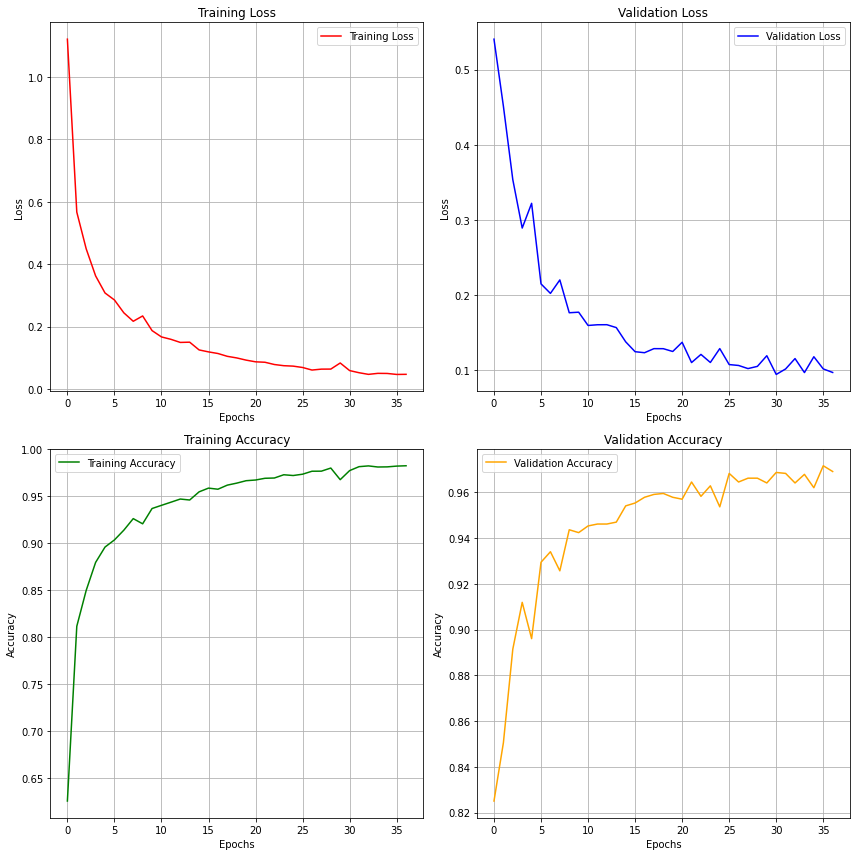

In [4]:
import matplotlib.pyplot as plt

epochs = range(len(train_loss_log))
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot Training Loss
axs[0, 0].plot(epochs, train_loss_log, label='Training Loss', color='red')
axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Validation Loss
axs[0, 1].plot(epochs, val_loss_log, label='Validation Loss', color='blue')
axs[0, 1].set_title('Validation Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Training Accuracy
axs[1, 0].plot(epochs, train_acc_log, label='Training Accuracy', color='green')
axs[1, 0].set_title('Training Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot Validation Accuracy
axs[1, 1].plot(epochs, val_acc_log, label='Validation Accuracy', color='orange')
axs[1, 1].set_title('Validation Accuracy')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].grid()


plt.tight_layout()
plt.show()